# Individual assignment Data mining 
### National Health and Nutrition Examination Survey

For this assignment we have a set of 6 different files with data available from survey research. 

In [1]:
import os
import pandas as pd
import LLMConnect
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             roc_auc_score, confusion_matrix, classification_report, 
                             silhouette_score)
from sklearn.preprocessing import MinMaxScaler


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from mlxtend.frequent_patterns import fpgrowth, association_rules


## Importing the data

In [2]:
df_diet = pd.read_csv("data/diet.csv")

In [3]:
[col for col in df_diet.columns if col.startswith("DR1")]

['DR1DRSTZ',
 'DR1EXMER',
 'DR1DBIH',
 'DR1DAY',
 'DR1LANG',
 'DR1MNRSP',
 'DR1HELPD',
 'DR1STY',
 'DR1SKY',
 'DR1TNUMF',
 'DR1TKCAL',
 'DR1TPROT',
 'DR1TCARB',
 'DR1TSUGR',
 'DR1TFIBE',
 'DR1TTFAT',
 'DR1TSFAT',
 'DR1TMFAT',
 'DR1TPFAT',
 'DR1TCHOL',
 'DR1TATOC',
 'DR1TATOA',
 'DR1TRET',
 'DR1TVARA',
 'DR1TACAR',
 'DR1TBCAR',
 'DR1TCRYP',
 'DR1TLYCO',
 'DR1TLZ',
 'DR1TVB1',
 'DR1TVB2',
 'DR1TNIAC',
 'DR1TVB6',
 'DR1TFOLA',
 'DR1TFA',
 'DR1TFF',
 'DR1TFDFE',
 'DR1TCHL',
 'DR1TVB12',
 'DR1TB12A',
 'DR1TVC',
 'DR1TVD',
 'DR1TVK',
 'DR1TCALC',
 'DR1TPHOS',
 'DR1TMAGN',
 'DR1TIRON',
 'DR1TZINC',
 'DR1TCOPP',
 'DR1TSODI',
 'DR1TPOTA',
 'DR1TSELE',
 'DR1TCAFF',
 'DR1TTHEO',
 'DR1TALCO',
 'DR1TMOIS',
 'DR1TS040',
 'DR1TS060',
 'DR1TS080',
 'DR1TS100',
 'DR1TS120',
 'DR1TS140',
 'DR1TS160',
 'DR1TS180',
 'DR1TM161',
 'DR1TM181',
 'DR1TM201',
 'DR1TM221',
 'DR1TP182',
 'DR1TP183',
 'DR1TP184',
 'DR1TP204',
 'DR1TP205',
 'DR1TP225',
 'DR1TP226',
 'DR1.300',
 'DR1.320Z',
 'DR1.330Z',
 'DR1BWATZ',

# Analyzing the vegatarians
 order for us to analyze the vegatarians in the data, we must find the vegatarians. However, in the data there is no self reported vegatarian question. However, what is available is in a .xpt file on https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DS1IDS_H.htm. In this file we can see what each user who is represented by a unique SEQN, what their daily food consisted out of. There are two separate data files, where we can find the food that has been eaten by the participant. DR1IFF_H.xpt  includes the food data of day 1 and DR2IFF_H.xpt contains the food data of day 2. Not every participant in the provided 5 data files from kaggle, has participated in the food eating evaluation interviews. So we will only take the rows where the sequence number exists in both food evaluating interviews and also in the general interview. 
 
In order to label the SEQN as vegetarian or non_vegatarian, we must implement a proxy to identify a vegetarian. As proxy we use whether an individual has eaten no meat, poultry or fish. 

In [5]:
df_day1 = pd.read_sas("data/DR1IFF_H.xpt")

In [6]:
print(f"A total of {len(df_day1.SEQN.unique())} unique SEQN numbers are in the dataset")
print(f"A total of {len(df_day1)} rows are in the dataset, which means that each individual has reported {round(len(df_day1)/len(df_day1.SEQN.unique()), ndigits=1)} different food items on day 1")

A total of 8661 unique SEQN numbers are in the dataset
A total of 131394 rows are in the dataset, which means that each individual has reported 15.2 different food items on day 1


In the day 1 dataset, there are 8661 different participants who have reported 15.2 different food items for a total of 13194 total food items in day 1. 

We now want to evaluate the food items efficiently, we can use a metric which is the food group item namely "DR1CCMTX". This metric devides all possible food items in into 16 groups. Below you can see the results. We see that there is an error, the extreme negative value (5.4 * e-79), should be 0, but this might be due to the xpt reading of the food. So we should round the vlaues of DR1CCMTX

In [7]:
df_day1.DR1CCMTX.unique()

array([5.39760535e-79, 1.00000000e+00, 9.00000000e+01, 2.00000000e+00,
       3.00000000e+00, 5.00000000e+00, 1.10000000e+01, 1.00000000e+01,
       9.00000000e+00, 1.20000000e+01, 4.00000000e+00, 1.40000000e+01,
       6.00000000e+00, 8.00000000e+00, 1.30000000e+01, 7.00000000e+00])

In [8]:
df_day1["DR1CCMTX"] = round(df_day1["DR1CCMTX"])
occurrences = df_day1["DR1CCMTX"].value_counts().sort_index()
occurrences

DR1CCMTX
0.0     75335
1.0     10947
2.0      5466
3.0      5300
4.0      5337
5.0     13313
6.0       832
7.0        52
8.0       491
9.0      3690
10.0      666
11.0     1781
12.0     2653
13.0      169
14.0      721
90.0     4641
Name: count, dtype: int64

In [9]:
len(df_day1[df_day1["DR1CCMTX"] == 0]["SEQN"].unique())

8648

## First found challenge
The food combination type metric "DR1CCMTX", includes a lot of 0 values. The value 0, refers to the food combination not having a specific code in the researchers coding system. We thought we might be able to be smart and exclude the participants that have eaten food that has food code 0. But this group consists 99.9% of the dataset, so we have to find a workaround. As there are only 721 instances of food that participants have eaten food that belongs to the poultry, meat and fish group, which is number 14

You can see a table that includes the foodtypes and their respective code below

![IMG](Images/Table-food-type-codes.png)
source:  https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/DRXFCD_H.htm

## How to label vegetarians

As the group of combination food codes has 57% undefined values, who might contain meat or fish. We must use a different approach to find out who in this dataset is vegetarian. There is another column that identifies what the food type can be in this dataset. It is the column DR1IFDCD, which has a column description of the USDA food code of the food, (called DR2IFDCD in day 2 dataset). So by identifying which DR1IFDCD food codes contain meat, poultry or fish, we should be able to correctly link participants to being vegetarian. 

The only missing piece that is left is to find out which food codes contain meat and which do not. Luckily, there is a description of food codes file available at the 

In [10]:
df_day1

,SEQN,WTDRD1,WTDR2D,DR1ILINE,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,...,DR1IM181,DR1IM201,DR1IM221,DR1IP182,DR1IP183,DR1IP184,DR1IP204,DR1IP205,DR1IP225,DR1IP226
0,73557.0,16888.327864,12930.890649,1.0,1.0,49.0,2.0,2.0,6.0,2.0,...,3.595000e+00,3.400000e-02,1.000000e-03,9.490000e-01,1.080000e-01,5.397605e-79,5.100000e-02,1.000000e-03,5.397605e-79,1.000000e-02
1,73557.0,16888.327864,12930.890649,2.0,1.0,49.0,2.0,2.0,6.0,2.0,...,5.397605e-79,5.397605e-79,5.397605e-79,4.000000e-03,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
2,73557.0,16888.327864,12930.890649,3.0,1.0,49.0,2.0,2.0,6.0,2.0,...,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
3,73557.0,16888.327864,12930.890649,4.0,1.0,49.0,2.0,2.0,6.0,2.0,...,8.100000e-02,5.397605e-79,5.397605e-79,1.030000e-01,3.100000e-02,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
4,73557.0,16888.327864,12930.890649,5.0,1.0,49.0,2.0,2.0,6.0,2.0,...,2.600000e-02,5.397605e-79,5.397605e-79,2.400000e-02,9.000000e-03,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131389,83731.0,5805.674812,4339.132077,23.0,1.0,49.0,2.0,2.0,12.0,6.0,...,3.798000e+00,3.800000e-02,5.397605e-79,3.372000e+00,4.790000e-01,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
131390,83731.0,5805.674812,4339.132077,24.0,1.0,49.0,2.0,2.0,12.0,6.0,...,5.260000e-01,5.000000e-03,5.397605e-79,4.730000e-01,8.200000e-02,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
131391,83731.0,5805.674812,4339.132077,25.0,1.0,49.0,2.0,2.0,12.0,6.0,...,1.483000e+00,1.500000e-02,5.397605e-79,1.346000e+00,1.980000e-01,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79
131392,83731.0,5805.674812,4339.132077,26.0,1.0,49.0,2.0,2.0,12.0,6.0,...,6.830000e-01,5.397605e-79,5.397605e-79,6.000000e-02,2.500000e-02,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79,5.397605e-79


### Importing dataset which contains food code descriptions
In this dataset we can find what each of the foodcodes means in plain english.

In [16]:
df_foodcodes_description = pd.read_sas("data/DRXFCD_H.xpt")

### Check if foodcodes are able to be linked in the previous dataset of the food interviews

In [74]:
df_day1["DR1IFDCD"][0] in df_foodcodes_description.DRXFDCD.unique()

True

The column "DR1IFDCD" from the  day 1 dataset can be linked to the column "DRXFDCD" in the food code description. So we are able to link both datasets together, and match the food codes with the descriptions. This will be important later

In [17]:
df_foodcodes_description["DRXFDCD"] = df_foodcodes_description["DRXFDCD"].apply(lambda x: int(x))
df_foodcodes_description

,DRXFDCD,DRXFCSD,DRXFCLD
0,11000000,"b'MILK, HUMAN'","b'Milk, human'"
1,11100000,"b'MILK, NFS'","b'Milk, NFS'"
2,11111000,"b'MILK, WHOLE'","b'Milk, whole'"
3,11111100,"b'MILK, LOW SODIUM, WHOLE'","b'Milk, low sodium, whole'"
4,11111150,"b'MILK, CALCIUM FORTIFIED, WHOLE'","b'Milk, calcium fortified, whole'"
...,...,...,...
8531,95323000,"b'SPORTS DRINK, LOW CALORIE'","b'Sports drink, low calorie'"
8532,95330100,"b'FLUID REPLACEMENT, ELECTROLYTE SOLUTION'","b'Fluid replacement, electrolyte solution'"
8533,95330500,"b'FLUID REPLACEMENT, 5% GLUCOSE IN WATER'","b'Fluid replacement, 5% glucose in water'"
8534,95341000,b'FUZE SLENDERIZE FORTIFIED LOW CALORIE FRUIT ...,b'FUZE Slenderize fortified low calorie fruit ...


### Interpretation of the data
As we can see from the table above, each unique food identifier, is reprented by a binary notation. However, the proability that we can infer what food is vegatarian or not is going to be very difficult by hand, it depends on how many different ingredients there are. 

### Binary notation
The column DRXFCSD and DRXFCLD, is represented by a binary string, b''. Such a notation might become an issue later on if we try to evaluate wheter a food item consist out of meat or not. So therefore let's transform the binary string into a list of individual words

In [18]:
def turn_binary_string_to_list(df):
    df["food_list"] = df["DRXFCSD"].apply(lambda x: str(x).replace("b'", "").replace("'", "").split(","))
    return df
df_foodcodes_description = turn_binary_string_to_list(df_foodcodes_description)

It is important to understand how many individual food items there are available. We might be able to use a trick to find if the ingredients contain meat or not. Or if there are not too many, we could do so by hand. 

In [38]:
unique_elemnts_food = set([food for food_list in df_foodcodes_description.food_list.values for food in food_list])
print(f"There are {len(unique_elemnts_food)} unique ingredients in the foodcodes description")

There are 6191 unique ingredients in the foodcodes description


In [19]:
def turn_food_df_to_dict(df):
    food_code_dict = {}
    df_food_code = df[["DRXFDCD", "food_list"]]
    for index, row in df_food_code.iterrows():
        food_code_dict[row["DRXFDCD"]] = row["food_list"]
    return food_code_dict
food_code_dict = turn_food_df_to_dict(df_foodcodes_description)

## Use of LLM to create food codes
Because the food codes are so diverse, it is not feasible to identify a resistance rule without relying on a large number of if-else statements to determine the appropriate food category. Our goal is to classify whether a food is vegetarian by leveraging an LLM to analyze each data row and identify whether the food description includes fish, red meat, white meat, poultry, dairy, or other food-related products; otherwise, it is labeled as “none.” This is implemented using an LLM through the LLM Connect python file, where the process is detailed. The classification is performed by providing the LLM with a carefully designed prompt, which is demonstrated in this notebook, in the code block below. The prompt is entered into GPT-4 mini, and the output, formatted in JSON, is then used to label the data and determine if an individual is vegetarian. While this approach may feel like venturing into a rabbit hole, it provides a structured and effective method for achieving the desired labeling.




        system_message = """
                You are a food detecting agent that responds only in JSON mode.
                Analyze the following list of JSON objects representing food meals and their ingredients.
                """
        user_task = """
        You are a food detecting agent that responds only in JSON mode.
        Analyze the following list of JSON objects representing food meals and their ingredients:
        {{input_json}}
        ---

        For each ingredient in each meal, determine if it contains any of the following categories, you are allowed to 
        label multiple ingredients as 1:
        - poultry
        - red meat
        - fish
        - shellfish
        - dairy products
        - other animal products

        Return the result as a JSON array of objects with the structure:
        "meals": [
            {
                "ingredient_list": "list of food ingredients",
                "meal_number: unique_id
                "poultry": 1 or 0,
                "red_meat": 1 or 0,
                "fish": 1 or 0,
                "shellfish": 1 or 0,
                "dairy_products": 1 or 0,
                "other_animal_products": 1 or 0,
                "none": 1 or 0
            }
        ]
        Only return the array of jsons in dict formats, nothing else.
        
        """

In [20]:

def turn_json_into_segments(json_to_divide, dict_per_chunk=30):
    

    smaller_json = {}
    json_list_combined = []
    for index,(key, json_dict) in enumerate(json_to_divide.items()):
        if index % dict_per_chunk ==0 and index !=0:
            json_list_combined.append(smaller_json)
            smaller_json = {}
        smaller_json[key] = json_dict
    json_list_combined.append(smaller_json)
    return json_list_combined
    


def detect_food_json_list_dict(json_list:str):
    json_list = turn_json_into_segments(json_to_divide=json_list,
                                        dict_per_chunk=30)    
    
    
    
    LLM_translator = LLMConnect.DetectFoodIngredients(model_name="gpt-4o-mini", max_tokens=9069)
    
    complete_food_labeled_json_dict = []
    
    for index, json_dict in enumerate(json_list):
        food_json= json.dumps(json_dict)
        food_labeled_json = LLM_translator.detect_food_ingredients(input_json= food_json
                                                               )
        
        complete_food_labeled_json_dict.append(food_labeled_json)
    return complete_food_labeled_json_dict
        
        
complete_food_json = detect_food_json_list_dict(json_list=food_code_dict)



/var/folders/f3/ykt1vfz96xz48try_trwdn440000gn/T/ipykernel_45696/823920892.py:24: UserWarning: WARNING! response_format is not default parameter.
                response_format was transferred to model_kwargs.
                Please confirm that response_format is what you intended.
  LLM_translator = LLMConnect.DetectFoodIngredients(model_name="gpt-4o-mini", max_tokens=9069)


I am sending a request to an LLM now
save_file_path =  json/data_1.json
save_file_path =  json/data_1.json
I am sending a request to an LLM now
save_file_path =  json/data_2.json
save_file_path =  json/data_2.json
I am sending a request to an LLM now
save_file_path =  json/data_3.json
save_file_path =  json/data_3.json
I am sending a request to an LLM now
save_file_path =  json/data_4.json
save_file_path =  json/data_4.json
I am sending a request to an LLM now
save_file_path =  json/data_5.json
save_file_path =  json/data_5.json
I am sending a request to an LLM now
save_file_path =  json/data_6.json
save_file_path =  json/data_6.json
I am sending a request to an LLM now
save_file_path =  json/data_7.json
save_file_path =  json/data_7.json
I am sending a request to an LLM now
save_file_path =  json/data_8.json
save_file_path =  json/data_8.json
I am sending a request to an LLM now
save_file_path =  json/data_9.json
save_file_path =  json/data_9.json
I am sending a request to an LLM now


In [22]:
with open("complete_food_codes.json", "w") as f:
    f.write(json.dumps(complete_food_json))

In [35]:
print(f"There are a total of {len(complete_food_json)} chunks of food jsons")
print(f"For a total of {len([food for chunk in complete_food_json for food in chunk["meals"]])} of individual food items")

There are a total of 285 chunks of food jsons
For a total of 8527 of individual food items


### Evaluating LLM output
As we can see from above, there are a total of 8527 individual food items that the LLM has returned. The structure of each chunk can be seen below.

`"meals": [
            {
                "ingredient_list": "list of food ingredients",\n
                "meal_number: unique_id
                "poultry": 1 or 0,
                "red_meat": 1 or 0,
                "fish": 1 or 0,
                "shellfish": 1 or 0,
                "dairy_products": 1 or 0,
                "other_animal_products": 1 or 0,
                "none": 1 or 0
            }
        ]`
        
We now have a list of chunks, each containing 30 individual food items. The first step is to create a large dictionary where each food number serves as the key, and the corresponding food codes are stored as the values. Once this dictionary is constructed, we need to verify that all data values are correctly loaded and accurately reflect the intended information. After ensuring the data’s accuracy, the final step is to match each individual food item to the corresponding entries in the food record table. This process ensures the integration and alignment of data for further analysis.

In [64]:
from copy import deepcopy
chunked_food_json = deepcopy(complete_food_json)

In [65]:
def turn_json_chunks_df(json_chunks):
    """
    groups the chunks of food_json output from the llm into a list of dictionaries
    :param json_chunks: 
    :return: 
    """
    complete_json = []
    for chunk in json_chunks:
        # Check if meals is in the chunk
        if "meals" in chunk:
            complete_json.extend(chunk["meals"])
        # If the llm named the chunk differently
        elif len(chunk.keys()) == 1:
            key_name = list(chunk.keys())[0]
            complete_json.extend(chunk[key_name])
        # If the LLM accidentally didn't give a key for the chunk
        elif len(chunk.keys()) == 9:
            complete_json.append(chunk)
        else:
            raise Exception("there is an issue with formatting")

    return complete_json

def turn_json_list_into_key_value_dict(json_list):
    """
    turns the list of dictionaries into a large dictionary, where each key is the unique food code and the value is the food encoding created by the LLM
    :param json_list: list of dictionaries of food items
    :return: 
    """
    food_json_dictionary = {json_dict["meal_number"]:json_dict for json_dict in json_list}
    [json_dict.pop("meal_number") for meal_number, json_dict in  food_json_dictionary.items()]
    return food_json_dictionary
        
exploded_food_json = turn_json_chunks_df(chunked_food_json)
print(f"there are a total of {len(exploded_food_json)} food items")
food_code_dictionary = turn_json_list_into_key_value_dict(exploded_food_json)

there are a total of 8527 food items


In [59]:
food_code_dictionary["22401000"]

{'ingredient_list': ['PORK ROAST', ' LOIN', ' COOKED', ' NS AS TO FAT'],
 'poultry': 0,
 'red_meat': 1,
 'fish': 0,
 'shellfish': 0,
 'dairy_products': 0,
 'other_animal_products': 1,
 'none': 0}

We now have a large dictionary, where each key is the unique food code and the value is the food code dictionary . We now transform the foodcode dictionary into a pandas dataframe. Subsequently, we want to merge this dataset with the food observerstion dataset of day 1 of the research participants. 

In [66]:
def turn_food_dictionary_into_pd(json_dictionary):
    """
    # Step 1: Convert the dictionary to a DataFrame
    dict_df = pd.DataFrame.from_dict(meal_dict, orient="index").reset_index()
    dict_df.rename(columns={"index": "food_code"}, inplace=True)
    :param json_dictionary: 
    :return: 
    """
    dict_df = pd.DataFrame.from_dict(json_dictionary, orient="index").reset_index()
    dict_df.rename(columns={"index": "food_code"}, inplace=True)
    return dict_df

food_code_df = turn_food_dictionary_into_pd(food_code_dictionary)
food_code_df

,food_code,ingredient_list,poultry,red_meat,fish,shellfish,dairy_products,other_animal_products,none
0,11000000,"[MILK, HUMAN]",0,0,0,0,1,0,0
1,11100000,"[MILK, NFS]",0,0,0,0,1,0,0
2,11111000,"[MILK, WHOLE]",0,0,0,0,1,0,0
3,11111100,"[MILK, LOW SODIUM, WHOLE]",0,0,0,0,1,0,0
4,11111150,"[MILK, CALCIUM FORTIFIED, WHOLE]",0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
8522,95323000,"[SPORTS DRINK, LOW CALORIE]",0,0,0,0,0,0,1
8523,95330100,"[FLUID REPLACEMENT, ELECTROLYTE SOLUTION]",0,0,0,0,0,0,1
8524,95330500,"[FLUID REPLACEMENT, 5% GLUCOSE IN WATER]",0,0,0,0,0,0,1
8525,95341000,[FUZE SLENDERIZE FORTIFIED LOW CALORIE FRUIT J...,0,0,0,0,0,0,1


## The data has some issues
The LLM labeled ingredients to contain poultry when the only ingredient was "egg", so it might be possible that there are some wrong predictions made by the LLM. Below you can see an example. This might be because of an issue with how I explained poultry in the prompt. As the example below labeled "egg drop soup" as poultry

In [70]:
food_code_df[food_code_df["food_code"]=="32300100"]

,food_code,ingredient_list,poultry,red_meat,fish,shellfish,dairy_products,other_animal_products,none
3075,32300100,[EGG DROP SOUP],1,0,0,0,0,0,0


### Merge dataframe observations day 1 with meat related product codes

Important to note, is that I named the unique food code a more descriptive name : food_code. But in the food description dataset this is actually called "DRXFDCD". However, in day 1 dataset the unique food code in the dataset this is actually called "DR1IFDCD". Therefore we have to rename the food_code column in the food description table to how the food code is called in the day_1 dataframe. 

In [88]:
def merge_food_code_df(df_day, df_food_codes, food_code_col_name):
    """
    Merges the obseverations of with the meat related labels
    :param df_day: 
    :param df_food_codes: 
    :param food_code_col_name: the name of the column in the df_day that represents the food code
    
    :return: 
    """
    df_day_to_merge = df_day.copy()
    # change the value of DR1IFDCD to integer. because it is in float representation when initially loaded
    df_day_to_merge[food_code_col_name] = df_day_to_merge[food_code_col_name].astype(int)
    df_food_codes_to_merge = df_food_codes.copy()
    
    df_food_codes_to_merge = df_food_codes_to_merge.rename(columns= {"food_code": food_code_col_name})
    df_food_codes_to_merge[food_code_col_name] = df_food_codes_to_merge[food_code_col_name].astype(int)
    df_day_to_merge = df_day_to_merge.merge(df_food_codes_to_merge, on=food_code_col_name, how="left")
    return df_day_to_merge

df_day_1_food_code = merge_food_code_df(df_day1, food_code_df, food_code_col_name="DR1IFDCD")
df_day_1_food_code

,SEQN,WTDRD1,WTDR2D,DR1ILINE,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,...,DR1IP225,DR1IP226,ingredient_list,poultry,red_meat,fish,shellfish,dairy_products,other_animal_products,none
0,73557.0,16888.327864,12930.890649,1.0,1.0,49.0,2.0,2.0,6.0,2.0,...,5.397605e-79,1.000000e-02,"[EGG, CHEESE & BACON GRIDDLE CAKE SANDWICH]",1.0,1.0,0.0,0.0,1.0,1.0,0.0
1,73557.0,16888.327864,12930.890649,2.0,1.0,49.0,2.0,2.0,6.0,2.0,...,5.397605e-79,5.397605e-79,"[COFFEE, BREWED]",0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,73557.0,16888.327864,12930.890649,3.0,1.0,49.0,2.0,2.0,6.0,2.0,...,5.397605e-79,5.397605e-79,"[SUCRALOSE-BASED SWEETENER, SUGAR SUBSTITUTE]",0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,73557.0,16888.327864,12930.890649,4.0,1.0,49.0,2.0,2.0,6.0,2.0,...,5.397605e-79,5.397605e-79,"[ORANGE JUICE, 100%, WITH CALCIUM, CANNED, BOT...",0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,73557.0,16888.327864,12930.890649,5.0,1.0,49.0,2.0,2.0,6.0,2.0,...,5.397605e-79,5.397605e-79,"[ORANGE, RAW]",0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131389,83731.0,5805.674812,4339.132077,23.0,1.0,49.0,2.0,2.0,12.0,6.0,...,5.397605e-79,5.397605e-79,"[WHITE POTATO, HOME FRIES]",0.0,0.0,0.0,0.0,0.0,0.0,1.0
131390,83731.0,5805.674812,4339.132077,24.0,1.0,49.0,2.0,2.0,12.0,6.0,...,5.397605e-79,5.397605e-79,"[BEANS, STRING, GREEN, CKD, NS FORM, MADE...",0.0,0.0,0.0,0.0,0.0,0.0,1.0
131391,83731.0,5805.674812,4339.132077,25.0,1.0,49.0,2.0,2.0,12.0,6.0,...,5.397605e-79,5.397605e-79,"[LENTILS, DRY, COOKED, MADE WITH OIL]",0.0,0.0,0.0,0.0,0.0,0.0,1.0
131392,83731.0,5805.674812,4339.132077,26.0,1.0,49.0,2.0,2.0,12.0,6.0,...,5.397605e-79,5.397605e-79,"[YOGURT, PLAIN, WHOLE MILK]",0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Grouping the day_1 table based on SEQN
To prepare the data for merging with another dataset, we need to ensure that each unique person (identified by SEQN) has a single aggregated value for their dietary labels. Since a person may have multiple food instances across the day, we will group all food instances by SEQN and aggregate the dietary labels (fish, white_meat, poultry, dairy, red_meat, other) to a single value for each label.

This will be done for each day separately, and we will create a function to handle this grouping and aggregation. The function will:
	1.	Accept the DataFrame and the day identifier as inputs.
	2.	Group the data by SEQN and aggregate each dietary column using the max function. This ensures that if any food item contains a particular dietary label, it is reflected in the aggregated value for the person.
	3.	Return the grouped DataFrame with one row per SEQN.

This function will be reusable for processing data for both the first and second days.

In [97]:
def group_dietary_labels_by_seqn(df):
    """
    Groups dietary labels by SEQN (person identifier) for a specific day.
    
    Parameters:
    df (DataFrame): The input DataFrame with food instances and dietary labels.
    
    Returns:
    DataFrame: A grouped DataFrame with one row per SEQN and aggregated dietary labels.
    """
    # Group by SEQN and aggregate dietary columns using the max function
    grouped_df = (
        df.groupby("SEQN")[["fish", "shellfish", "poultry", "dairy_products", "red_meat", "other_animal_products", "none"]]
        .sum()
        .reset_index()
    )
    grouped_df = grouped_df.rename(columns={"none": "no_animal_products"})
    
    
    return grouped_df

# Example usage for the first day
grouped_day1 = group_dietary_labels_by_seqn(df_day_1_food_code)

# If you have a second day's data, you can use the same function:
# grouped_day2 = group_dietary_labels_by_seqn(merged_df_day2, "Day 2")

grouped_day1

,SEQN,fish,shellfish,poultry,dairy_products,red_meat,other_animal_products,no_animal_products
0,73557.0,0.0,0.0,1.0,3.0,2.0,3.0,8.0
1,73558.0,1.0,2.0,0.0,4.0,0.0,0.0,3.0
2,73559.0,0.0,0.0,0.0,4.0,1.0,1.0,22.0
3,73560.0,0.0,0.0,0.0,8.0,2.0,1.0,9.0
4,73561.0,0.0,0.0,0.0,4.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...
8656,83724.0,0.0,0.0,2.0,5.0,0.0,1.0,17.0
8657,83727.0,0.0,0.0,1.0,7.0,4.0,2.0,13.0
8658,83728.0,0.0,0.0,1.0,7.0,2.0,0.0,11.0
8659,83729.0,3.0,0.0,0.0,3.0,1.0,0.0,25.0


# Grouping the day_2 eating habits
For day two, we aim to replicate the same process we performed for day one. Specifically, we want to determine, for each unique sequence number, how many times during the day an individual consumed poultry, red meat, other types of meat, dairy, fish, shellfish, or other animal products—or if they consumed none of these at all. This data will provide us with valuable insights.

In the second day, the food code is called differently. It is called "DR2IFDCD", so we have to adjust the process slightly

To achieve this, we need to perform all the necessary preprocessing steps. Which consists of merging the food codes on day_2 dataset, and then grouping them together based on SEQN

### Steps
1. Load day_2 data into pandas dataframe
2. Add meat related product labels to day_2 data based on Food identifier 
3. Group the data based on SEQN and sum up all values

In [98]:
df_day2 = pd.read_sas("data/DR2IFF_H.xpt")
grouped_day2 = group_dietary_labels_by_seqn(
    df= merge_food_code_df(
        df_day=df_day2,
        df_food_codes=food_code_df,
        food_code_col_name= "DR2IFDCD"
    )
)
grouped_day2

,SEQN,fish,shellfish,poultry,dairy_products,red_meat,other_animal_products,no_animal_products
0,73557.0,0.0,0.0,1.0,0.0,2.0,2.0,10.0
1,73558.0,0.0,0.0,2.0,3.0,1.0,0.0,3.0
2,73559.0,1.0,0.0,0.0,5.0,0.0,1.0,12.0
3,73560.0,0.0,0.0,0.0,2.0,2.0,0.0,6.0
4,73561.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...
7568,83724.0,0.0,0.0,3.0,2.0,1.0,1.0,12.0
7569,83727.0,0.0,0.0,2.0,6.0,3.0,2.0,10.0
7570,83728.0,0.0,0.0,0.0,6.0,1.0,0.0,18.0
7571,83729.0,1.0,0.0,1.0,3.0,0.0,0.0,12.0


## Statistical differences between both days
The data in day_1 is gathered by a researcher during an interview with the participant in person. While the second interview in day_2 was done over the phone. In both occasions, the participant was asked about its eating habits of the past 24 hours. However, we can see that the distribution is much different between both days. People should eat the same amount between different days. But in day_2, there are fewer observations of food instances. On top of that, not everyone who participated in day_1, also participated in day_2 as people were not able to pick up the phone in every case (Storz et al, 2022)

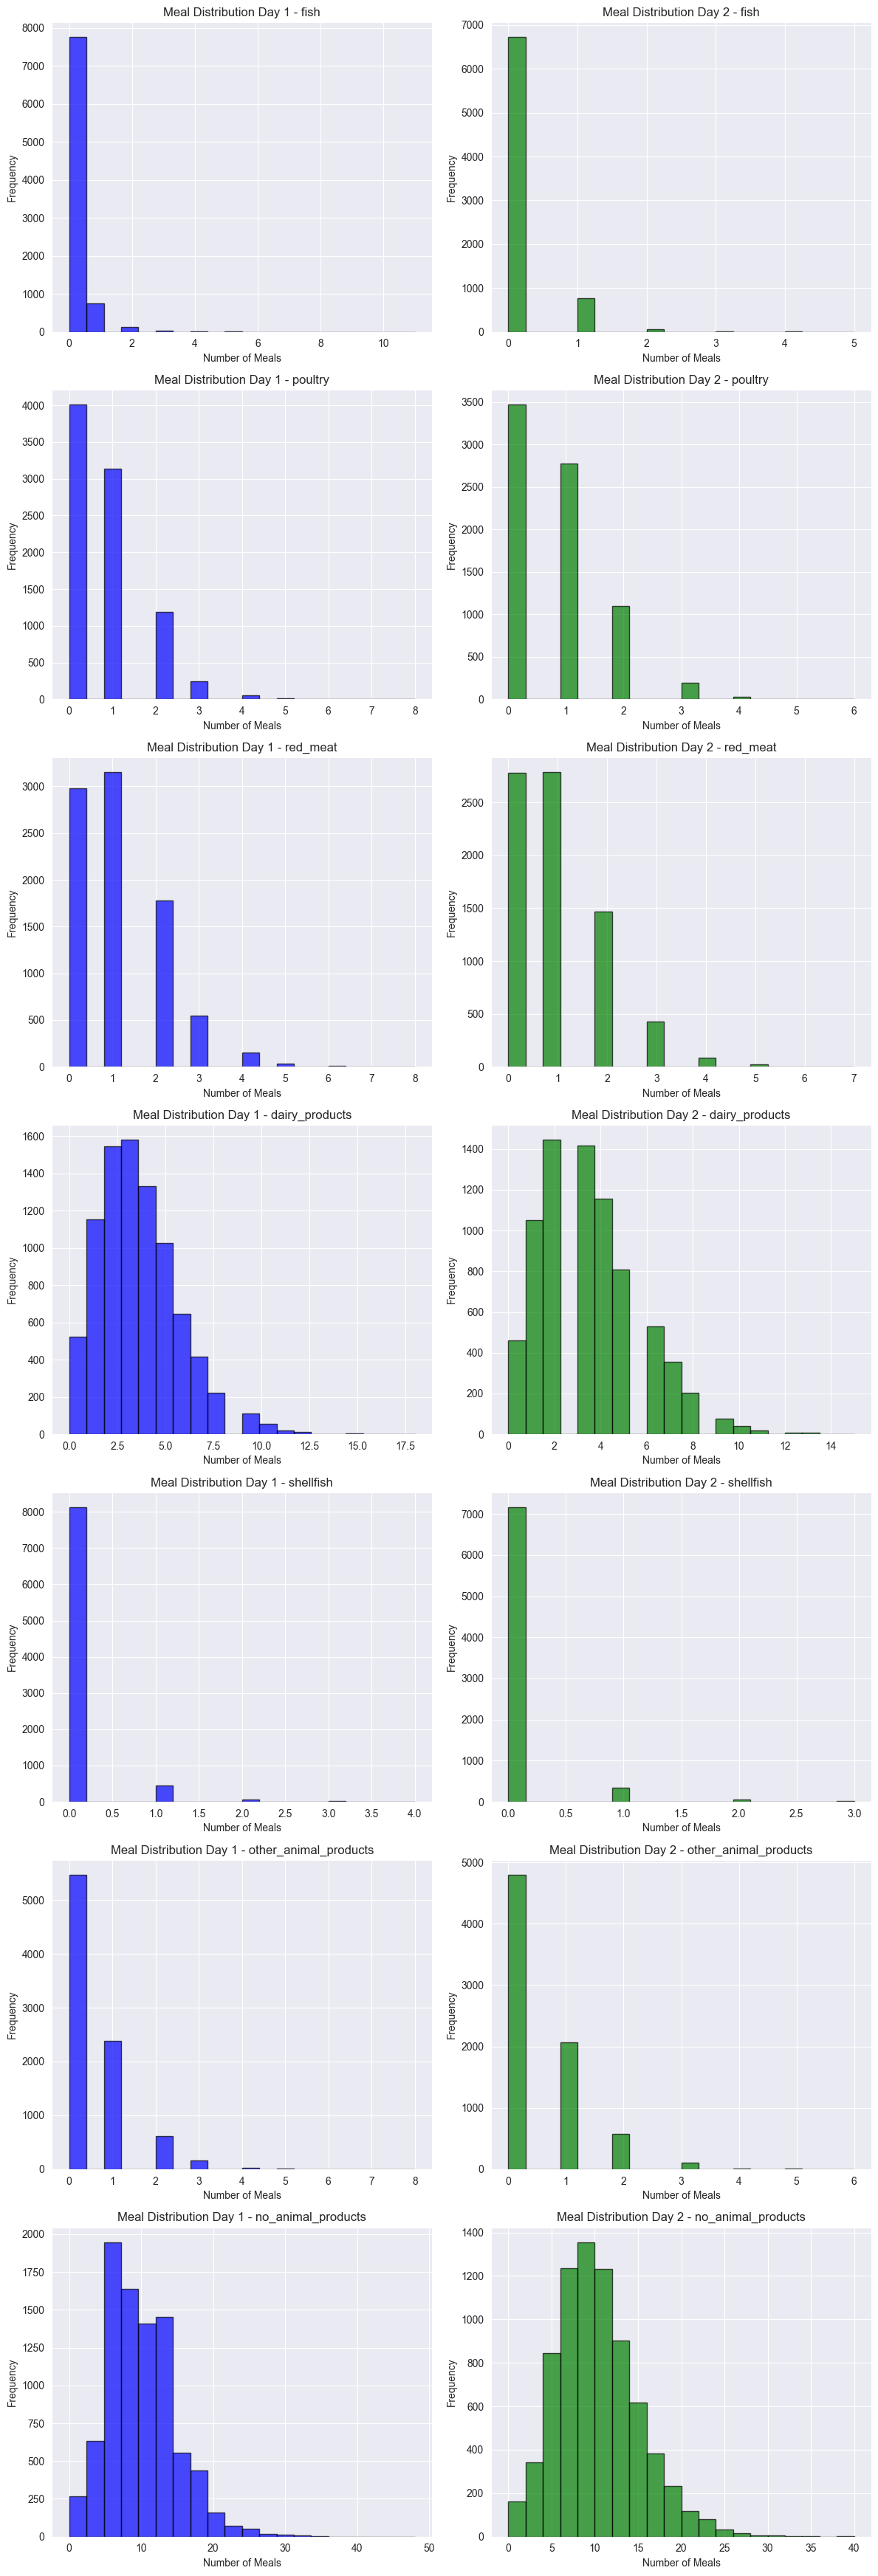

In [99]:
import matplotlib.pyplot as plt

def plot_meal_distributions(day1_data, day2_data, columns, title_prefix=""):
    """
    Plots distributions of meals for given categories for day one and day two.
    
    Parameters:
    - day1_data: DataFrame with data for day one
    - day2_data: DataFrame with data for day two
    - columns: List of column names representing the categories (e.g., fish, poultry)
    - title_prefix: String prefix for the title of the plots
    """
    # Set up the figure with subplots (rows = len(columns), cols = 2 for day1 and day2)
    num_categories = len(columns)
    fig, axes = plt.subplots(nrows=num_categories, ncols=2, figsize=(12, 5 * num_categories))
    
    # Ensure axes is a 2D array for consistent handling
    axes = axes.reshape((num_categories, 2))
    
    # Loop through each category and plot distributions
    for i, column in enumerate(columns):
        # Day 1 plot
        axes[i, 0].hist(day1_data[column], bins=20, alpha=0.7, color="blue", edgecolor="black")
        axes[i, 0].set_title(f"{title_prefix} Day 1 - {column}")
        axes[i, 0].set_xlabel("Number of Meals")
        axes[i, 0].set_ylabel("Frequency")
        
        # Day 2 plot
        axes[i, 1].hist(day2_data[column], bins=20, alpha=0.7, color="green", edgecolor="black")
        axes[i, 1].set_title(f"{title_prefix} Day 2 - {column}")
        axes[i, 1].set_xlabel("Number of Meals")
        axes[i, 1].set_ylabel("Frequency")
    
    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Example Usage
# Define the columns for the animal product categories
columns = ["fish", "poultry", "red_meat", "dairy_products", "shellfish", "other_animal_products", "no_animal_products"]

# Assuming 'grouped_day1' and 'grouped_day2' are the DataFrames for day one and day two
plot_meal_distributions(grouped_day1, grouped_day2, columns, title_prefix="Meal Distribution")

# Merge both days into a single day

The number of participants in Day 2 is lower than in Day 1 because not everyone participated on the second day. To strengthen our proxy for determining whether someone is vegetarian, we will include only those participants who are present in both Day 1 and Day 2 datasets. To achieve this, we will group the data together and filter it to retain only the sequence numbers that are present in both data frames. This approach ensures that our analysis is based on participants with complete data from both days.

We group both days together in the same table, and filter for participants that have participated in day_1 and day_2

In [104]:
def group_days(df_1, df_2):
    """
    Groups participants from Day 1 and Day 2, retaining only those who participated on both days.
    Merges the data for both days and sums the values for specific columns.
    
    Parameters:
    - df_1: DataFrame for Day 1
    - df_2: DataFrame for Day 2
    
    Returns:
    - DataFrame with summed values for participants present on both days.
    """
    participants_day_1 = set(df_1["SEQN"].unique())
    participants_day_2 = set(df_2["SEQN"].unique())
    
    # Find participants present in both days
    participants_both_days = participants_day_1.intersection(participants_day_2)
    
    # Filter both dataframes to include only participants present in both days
    filtered_day_1 = df_1[df_1["SEQN"].isin(participants_both_days)]
    filtered_day_2 = df_2[df_2["SEQN"].isin(participants_both_days)]
    
    # merge both together and sum up all the values
    columns = ["fish", "poultry", "red_meat", "dairy_products", "shellfish", "other_animal_products", "no_animal_products"]
    # Merge both DataFrames by SEQN and sum the values for the specified columns
    merged_df = pd.concat([filtered_day_1, filtered_day_2])
    grouped_df = merged_df.groupby("SEQN")[columns].sum().reset_index()
    
    return grouped_df

food_df_both_days = group_days(grouped_day1, grouped_day2)
food_df_both_days

,SEQN,fish,poultry,red_meat,dairy_products,shellfish,other_animal_products,no_animal_products
0,73557.0,0.0,2.0,4.0,3.0,0.0,5.0,18.0
1,73558.0,1.0,2.0,1.0,7.0,2.0,0.0,6.0
2,73559.0,1.0,0.0,1.0,9.0,0.0,2.0,34.0
3,73560.0,0.0,0.0,4.0,10.0,0.0,1.0,15.0
4,73561.0,0.0,0.0,0.0,9.0,0.0,0.0,6.0
...,...,...,...,...,...,...,...,...
7568,83724.0,0.0,5.0,1.0,7.0,0.0,2.0,29.0
7569,83727.0,0.0,3.0,7.0,13.0,0.0,4.0,23.0
7570,83728.0,0.0,1.0,3.0,13.0,0.0,0.0,29.0
7571,83729.0,4.0,1.0,1.0,6.0,0.0,0.0,37.0


# Laboratory results dataframe and questionare results dataframe

Now that we have our variables prepared, the next step is to gather the laboratory results data and the questionnaire data. From the questionnaire data, we will use a specific column to determine whether participants have been diagnosed with osteoporosis. Additionally, from the laboratory data, we will extract the results of blood tests. Using this combined information, we will proceed with the analysis to explore the relationships between dietary patterns, blood test results, and osteoporosis diagnosis.

In [105]:
df_questionare = pd.read_csv("data/questionnaire.csv")
df_questionare

,SEQN,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ101,ALQ110,ALQ120Q,ALQ120U,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,3.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,1.0,NaN,NaN,NaN,NaN,1.0,NaN,7.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,83727,NaN,NaN,NaN,3.0,NaN,1.0,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,150.0,26.0,NaN,NaN,NaN
10171,83728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10172,83729,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,155.0,135.0,NaN,195.0,42.0,NaN,NaN,NaN
10173,83730,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [122]:
df_questionare = df_questionare.rename(columns={"OSQ060": "has_osteoporosis"})
df_y_label = df_questionare["has_osteoporosis"]

df_y_label = df_y_label.fillna(0)
df_y_label.value_counts()

has_osteoporosis
0.0    6360
2.0    3481
1.0     322
9.0      12
Name: count, dtype: int64

### Interpretation of the questionare 

The question wheter it was asked if someone has osteoporosis, is only asked when participants were 40 years or older (https://wwwn.cdc.gov/Nchs/Data/Nhanes/Public/2013/DataFiles/OSQ_H.htm#OSQ060). Therefore, to make knowledgeable conclusions. Further in the research, we will remove the participants that have not received this answer in our predictive model. 

We renamed the column OSQ060 to has_osteoporosis, to give the column a more descriptive name. The question OSQ060 in the questionare has as description:
- Has a doctor ever told {you/SP} that {you/s/he} had osteoporosis, sometimes called thin or brittle bones?

Value meaning: 
- 0 = Person is not given the question because he/she is younger than 40 years
- 1 = Yes person has osteoporosis
- 2 = No person has not osteoporosis
- 9 = Person doesn't know

We will give the number 9, the number 1, and assume that the person doesn't have osteoporosis. 


In [125]:
df_y_label

0        2.0
1        2.0
2        1.0
3        0.0
4        2.0
        ... 
10170    0.0
10171    0.0
10172    2.0
10173    0.0
10174    0.0
Name: has_osteoporosis, Length: 10175, dtype: float64

### Creating the y label for predictive model

The questionare dataframe will be used to form a y label. The column has_osteoporosis (original name "OSQ060"), will become a binary y label. The participants that have not answered this question because they were too young are excluded (0). The participants that didn't know if the doctor told them they has osteoporosis (9) or answered with no to (1) , will get the label 0 has_osteoporosis. And the participants that answered with yes (2), will receive value 1 for the label ha_osteoporosis.

In [128]:
def get_y_label_from_questionaire(df):
    

    df_osteoporosis = df[
        (df["has_osteoporosis"] == 1) | 
        (df["has_osteoporosis"] == 2) | 
        (df["has_osteoporosis"] == 9)
        ]
    df_osteoporosis = df_osteoporosis.replace({9: 0, 1: 0, 2: 1})
    return df_osteoporosis[["SEQN", "has_osteoporosis"]]

    
df_y_label = get_y_label_from_questionaire(df_questionare)
df_y_label

,SEQN,has_osteoporosis
0,73557,1.0
1,73558,1.0
2,73559,0.0
4,73561,1.0
5,73562,1.0
...,...,...
10164,83721,1.0
10166,83723,1.0
10167,83724,1.0
10169,83726,1.0


In [106]:
df_lab = pd.read_csv("data/labs.csv")
df_lab

,SEQN,URXUMA,URXUMS,URXUCR.x,URXCRS,URDACT,WTSAF2YR.x,LBXAPB,LBDAPBSI,LBXSAL,...,URXUTL,URDUTLLC,URXUTU,URDUTULC,URXUUR,URDUURLC,URXPREG,URXUAS,LBDB12,LBDB12SI
0,73557,4.3,4.3,39.0,3447.6,11.03,NaN,NaN,NaN,4.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,524.0,386.7
1,73558,153.0,153.0,50.0,4420.0,306.00,NaN,NaN,NaN,4.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,507.0,374.2
2,73559,11.9,11.9,113.0,9989.2,10.53,142196.890197,57.0,0.57,3.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,732.0,540.2
3,73560,16.0,16.0,76.0,6718.4,21.05,NaN,NaN,NaN,NaN,...,0.062,0.0,0.238,0.0,0.0071,0.0,NaN,3.83,NaN,NaN
4,73561,255.0,255.0,147.0,12994.8,173.47,142266.006548,92.0,0.92,4.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,225.0,166.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9808,83727,1.9,1.9,47.0,4154.8,4.04,67775.162806,88.0,0.88,4.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,720.0,531.4
9809,83728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9810,83729,6.0,6.0,117.0,10342.8,5.13,NaN,NaN,NaN,4.1,...,0.135,0.0,0.132,0.0,0.0081,0.0,2.0,9.75,388.0,286.3
9811,83730,4.5,4.5,86.0,7602.4,5.23,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Chosen the features to include in our model

- LBDB12SI -> Vitamin B12 (pmol/L)	

In [124]:
df_lab["LBDB12SI"]

0       386.7
1       374.2
2       540.2
3         NaN
4       166.1
        ...  
9808    531.4
9809      NaN
9810    286.3
9811      NaN
9812      NaN
Name: LBDB12SI, Length: 9813, dtype: float64